In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os
import time

import pandas as pd # Excel
import struct # Binary writing

import scipy.io as sio # Read .mat files
import h5py

import scipy.signal
import scipy.ndimage

import sklearn.decomposition as skdec
import sklearn.linear_model as sklin
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import normalize
from sklearn import svm
from sklearn import neighbors
import sklearn.metrics as skmet

C:\Users\sarytky\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [28]:
#Principal component analysis
def PCA(features,ncomp):	
    #Feature dimension, x=num variables,N=num observations
    x,N = np.shape(features)		
    #Mean feature
    mean_f = np.mean(features,axis=1)
    #Centering
    centrd = np.zeros((x,N))
    for k in range(N):
        centrd[:,k] = features[:,k]-mean_f

    #PCs from covariance matrix if N>=x, svd otherwise
    if x<=N:
        #Covariance matrix
        Cov = np.zeros((x,x))
        f = np.zeros((x,1))
        for k in range(N):		
            f[:,0] = centrd[:,k]
            Cov = Cov+1/N*np.matmul(f,f.T)

        #Eigen values
        E,V = np.linalg.eig(Cov)		
        #Sort eigenvalues and vectors to descending order
        idx = np.argsort(E)[::-1]
        V = np.matrix(V[:,idx])
        E = E[idx]

        for k in range(ncomp):						
            s = np.matmul(V[:,k].T,centrd).T			
            try:
                score = np.concatenate((score,s),axis=1)
            except NameError:
                score = s
            p = V[:,k]
            try:
                pcomp = np.concatenate((pcomp,p),axis=1)
            except NameError:
                pcomp = p
    else:
        #PCA with SVD
        u,s,v = np.linalg.svd(centrd,compute_uv=1)
        pcomp = v[:,:ncomp]
        score = np.matmul(u,s).T[:,1:ncomp]		
    return pcomp,score

#Scikit PCA
def ScikitPCA(features,ncomp):
    pca = skdec.PCA(n_components=ncomp, svd_solver='full')
    #score = pca.fit(features).transform(features)
    score = pca.fit_transform(features)
    return pca, score

#Regression
def regress(features,score):
    pred = []
    #Leave one out split
    loo = LeaveOneOut()
    for trainidx, testidx in loo.split(features):
        #Indices
        X_train, X_test = features[trainidx], features[testidx]
        X_test -= X_train.mean(0)
        X_train -= X_train.mean(0)

        Y_train, Y_test = score[trainidx], score[testidx]
        #Linear regression
        regr = sklin.Ridge(alpha=1)
        regr.fit(X_train,Y_train)
        #Predicted score
        pred.append(regr.predict(X_test))

    return np.array(pred), regr.coef_

#Logistic regression
def logreg(features,score):
    pred = []
    #Leave one out split
    loo = LeaveOneOut()
    for trainidx, testidx in loo.split(features):
        #Indices
        X_train, X_test = features[trainidx], features[testidx]
        X_test -= X_train.mean(0)
        X_train -= X_train.mean(0)

        Y_train, Y_test = score[trainidx], score[testidx]		
        #Linear regression
        regr = sklin.LogisticRegression(solver='newton-cg',max_iter=1000)
        regr.fit(X_train,Y_train)
        #Predicted score
        P = regr.predict_proba(X_test)
        pred.append(P)

    pred = np.array(pred)
    pred = pred[:,:,1]
    return pred.flatten()

def loadbinary(path, datatype = np.int32):
    if datatype == np.float64:
        bytesarray = np.fromfile(path, dtype = np.int64) # read everything as int32
    else:
        bytesarray = np.fromfile(path, dtype = np.int32) # read everything as int32
    w = bytesarray[0]
    l = int((bytesarray.size - 1) / w)
    with open(path, "rb") as f: # open to read binary file
        if datatype == np.float64:
            f.seek(8) # skip first integer (width)
        else:
            f.seek(4) # skip first integer (width)
        features = np.zeros((w,l))
        for i in range(w):
            for j in range(l):
                if datatype == np.int32:
                    features[i, j] = struct.unpack('<i', f.read(4))[0]  
                    # when reading byte by byte (struct), 
                    #data type can be defined with every byte
                elif datatype == np.float32:
                    features[i, j] = struct.unpack('<f', f.read(4))[0]  
                elif datatype == np.float64:
                    features[i, j] = struct.unpack('<d', f.read(8))[0]  
        return features

def writebinaryweights(path, ncomp, eigenvectors, singularvalues, weights, mean):
    # Input eigenvectors in shape: components, features
    with open(path, "wb") as f:
        f.write(struct.pack('<i', eigenvectors.shape[1])) # Width
        f.write(struct.pack('<i', ncomp)) # Number of components
        # Eigenvectors 
        for j in range(eigenvectors.shape[1]):
            for i in range(eigenvectors.shape[0]): # Write row by row, component at a time
                f.write(struct.pack('<f', eigenvectors[i, j]))
        # Singular values
        for i in range(singularvalues.shape[0]):
            f.write(struct.pack('<f', singularvalues[i]))
        # Weights
        for i in range(weights.shape[0]):
            f.write(struct.pack('<d', weights[i]))
        for i in range(mean.shape[0]):
            f.write(struct.pack('<d', mean[i]))
    return True

def writebinaryimage(path, image):
    with open(path, "wb") as f:
        f.write(struct.pack('<i', image.shape[0])) # Width
        # Image values as float
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                f.write(struct.pack('<f', image[i, j]))
    return True

(32, 36)
1.1102287422737334e-09
Linear regression:
Sum of differences to actual grades
17.247236335707
(32, 36)
[ 72981.69444444  69902.30555556      0.            190.77777778
   2024.63888889   6115.13888889   9087.77777778   7083.69444444
   2719.61111111    351.75            0.         115310.61111111
      0.            241.11111111   9692.44444444  26931.41666667
  31327.11111111  28872.97222222  11496.33333333    282.83333333
      0.          34039.77777778   6671.13888889  13672.25
   8390.47222222   7282.30555556   7168.47222222   7271.5
   8368.16666667  13541.88888889   6752.          63765.80555556]
(10, 32)
[47418.62893192 31218.48037413 14169.25582718  5148.79588716
  3497.5375238   2492.21495181  2217.7767267   1932.18664306
  1663.95436583  1409.5467417 ]
Sum of differences to actual grades
12.484125771335133
Confusion matrix
[[ 5  3  0  0]
 [ 1  7  3  0]
 [ 0  0 11  2]
 [ 0  0  2  2]]
Mean squared error, Area under curve
0.1966336527451777 0.8928571428571428
-- 3.9361

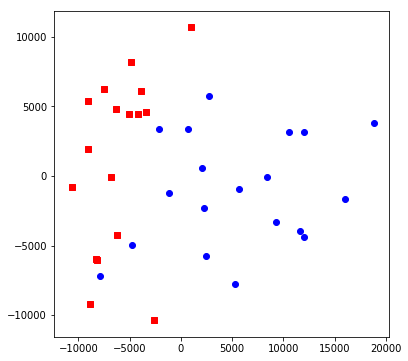

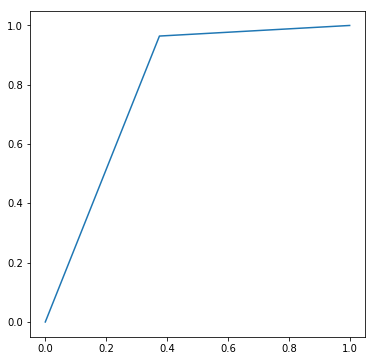

Linear regression


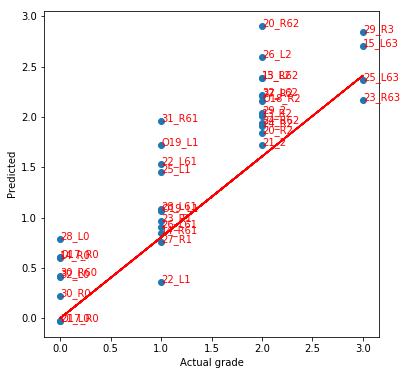

Logistic regression


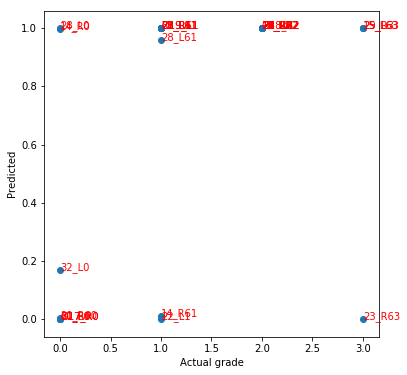

In [43]:
#Start time
start_time = time.time()

# load features from file
path = r'C:\Users\sarytky\Desktop\trials'

# Load grades to array
grades = pd.read_excel(path + r'\PTAgreiditjanaytteet.xls', 'Sheet1')
grades = pd.DataFrame(grades).values
filelist = grades[:,0]
g = grades[:,2].astype('int')
grades = grades[:,1:2]

#LBP features
features = loadbinary(path + r'\features.dat')

## Remove first two samples
#features = features[:,1:]
#g = g[1:]

#PCA
m = np.mean(features, 1)
print(np.shape(features))
dataadjust = features.T - m
ncomp = 10
pca, score = ScikitPCA(features.T, ncomp)
pca2, score2 = ScikitPCA(dataadjust, ncomp)
print(np.sum(np.abs(score2.flatten() - score.flatten())))
#pcomp,score2 = PCA(features, ncomp)

# Regression
pred1, weights = regress(score, g)
pred2 = logreg(score, g>0)
#pred2 = IP.logreg(features.T,g>0)

# Assign exceeding values to 0 and 3
for p in range(len(pred1)):
    if pred1[p]<0:
        pred1[p] = 0
    if pred1[p] > 3:
        pred1[p]=3
        
#Evaluation
print('Linear regression:')
print('Sum of differences to actual grades')
print(np.sum(np.abs(pred1.flatten() - g)))

# Save calculated weights
writebinaryweights(path + r'\weights.dat', ncomp, pca.components_, pca.singular_values_, weights, m)

# Pretrained PCA and regression
print(np.shape(features))
m = np.mean(features, 1)
print(m)
print(np.shape(pca.components_))

print(pca.singular_values_)
dataadjust = features.T - m
#dataadjust = features.T
pcaref = np.matmul(dataadjust, pca.components_.T)
#pcaref = np.divide(pcaref, pca.singular_values_)
#print('PCA reference')
#print(pcaref)
reference = np.matmul(pcaref, weights)
#print('Reference grades')
#print(reference)
print('Sum of differences to actual grades')
print(np.sum(np.abs((reference + 1.5).flatten() - g)))
## Replace with multiplication

pred1 = reference + 1.5

##Pretrained vs trained
#fig = plt.figure(figsize=(6,6))
#ax3 = fig.add_subplot(111)
#ax3.scatter(reference, pred1)

#
# Visualization
#

#Plotting the prediction
a = g
b = np.round(pred1).astype('int')

#Plotting PCA scores
x = score[:,0]
y = score[:,1]
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)
ax1.scatter(score[g<2,0],score[g<2,1],marker='o',color='b',label='Normal')
ax1.scatter(score[g>1,0],score[g>1,1],marker='s',color='r',label='OA')

C1 = skmet.confusion_matrix(a,b)
MSE1 = skmet.mean_squared_error(a,pred1)
fpr, tpr, thresholds = skmet.roc_curve(a>0, np.round(pred1)>0, pos_label=1)
AUC1 = skmet.auc(fpr,tpr)	
AUC1 = skmet.roc_auc_score(a>0,pred2)
t = time.time()-start_time
m, b = np.polyfit(a, pred1.flatten(), 1)
R2 = skmet.r2_score(a,pred1.flatten())

print('Confusion matrix')
print(C1)
print('Mean squared error, Area under curve')
print(MSE1,AUC1)#,MSE2,MSE3,MSE4)
print("-- %s seconds --" % t)
print('R2 score')
print(R2)

# Area under curve
fig0  = plt.figure(figsize=(6,6))
ax0 = fig0.add_subplot(111)
ax0.plot(fpr,tpr)
plt.show()

# Grade vs. predicted
print('Linear regression')
fig = plt.figure(figsize=(6,6))
ax2 = fig.add_subplot(111)
ax2.scatter(a,pred1.flatten())
ax2.plot(a,m*a,'-',color='r')
ax2.set_xlabel('Actual grade')
ax2.set_ylabel('Predicted')
for k in range(len(g)):
    txt = filelist[k]
    txt = txt[0:-4]
    txt = txt+str(g[k])
    ax2.annotate(txt,xy=(a[k],pred1[k]),color='r')
plt.show()

# Logistic regression
print('Logistic regression')
fig = plt.figure(figsize=(6,6))
ax3 = fig.add_subplot(111)
ax3.scatter(g,pred2.flatten())
ax3.set_xlabel('Actual grade')
ax3.set_ylabel('Predicted')
for k in range(len(g)):
    txt = filelist[k]
    txt = txt[0:-4]
    txt = txt+str(g[k])
    ax3.annotate(txt,xy=(g[k],pred2[k]),color='r')
plt.show()

#Save everything
dict = {'g':g,'pred1':pred1,'pred2':pred2}
sio.savemat(path + r'\regressresults.mat',dict)